In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using LM-BFGS with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each triplet of parameters $\alpha = (\beta, \gamma,m) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import gurobipy as GRB
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy           import logical_and, where, allclose, full, clip, arctan, exp, pi, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from matplotlib import colormaps
from scipy.interpolate   import CubicHermiteSpline
from scipy.sparse.linalg import LinearOperator
from scipy.sparse    import eye as speye
from scipy.sparse    import bmat
from numpy.polynomial.chebyshev import chebpts1

# Problem setup

In [4]:
# Total population
n = 400
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code

## Generation of $\widehat \rho$

We are going to generate a choice for $\widehat\rho$ based on a solution of the system that satisfies the initial condition. For this, we find $\widehat\rho_{\mathsf e}$ as the solution of the SIR model for the choice $\alpha = (0.01,0.5)$. Then we compute the smooth transformation $p_1 = \widehat{\rho}_{\mathsf e} + 4 \big(\sin(\widehat{\rho}_{\mathsf e}) - \sin(\rho_0) \big)$.

In [5]:
T  = 3                             # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Rates for ρ̂ₑ:
βₑ, γₑ, mₑ = 0.007, 0.1, 0.05
αₑ = asarray([βₑ, γₑ, mₑ])

In [7]:
print('Basic reproduction number:', n*βₑ/(γₑ+mₑ))

Basic reproduction number: 18.666666666666664


In [8]:
def SIRD(t, z, β,γ,m):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [9]:
sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=(βₑ, γₑ, mₑ), t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


In [10]:
ρ̂ₑ  = sol.y;    ρ = ρ̂ₑ.copy()
dρ̂ₑ = asarray(SIRD(0,ρ̂ₑ,βₑ,γₑ,mₑ))

Apply smooth transformation:

In [11]:
p_1 = ρ̂ₑ + 4*sin(ρ̂ₑ) - 4*sin(ρ̂ₑ[:,0])[::,np.newaxis]

Now we split the integral $[0,T]$ into $k$ periods and compute the rolling average of $p_1$ on each subinterval yielding a vector:
\begin{align*}
    (p_2)_i = \int\limits_{t_{i}}^{t_{i+1}} \frac{p_1}{t_{i+1} - t_i} \, \mathrm{d} s  \qquad \qquad \forall i \in [0:k-1].
\end{align*}

In [12]:
from scipy.integrate import quad_vec

In [13]:
SmoothVar = lambda t: sol.sol(t) + 4 * sin(sol.sol(t) - 4 * sin(ρ̂ₑ[:,0]) )

In [14]:
num_subintervals = 50
t_values = np.linspace(0, T, num_subintervals + 1)

In [15]:
IntQUADPACK = [quad_vec(SmoothVar, t_values[i], t_values[i+1], full_output=False)   for i in range(num_subintervals)]
averages    = asarray([IntQUADPACK[i][0]    for i in range(num_subintervals)]) / ( t_values[1] - t_values[0] )
print('Maximum integration error estimate: {0:.2e}'.format(asarray([IntQUADPACK[i][1]    for i in range(num_subintervals)]).max()) )

Maximum integration error estimate: 8.97e-09


Now let's keep monotony of the function: (a) susceptibles cannot increase, (b) recovered cannot decrease, (c) infected cannot decrease until the peak is reached.

In [16]:
MonAv = averages.copy()
for i in range(1,num_subintervals):
    # Susceptible
    if MonAv[i,0] > MonAv[i-1,0]:
        MonAv[i,0] = MonAv[i-1,0]
    # Recovered
    if MonAv[i,2] < MonAv[i-1,2]:
        MonAv[i,2] = MonAv[i-1,2]
    # Infected
    idx_cut = np.digitize(Tₑ[np.argmax(ρ̂ₑ.T[:,1])], t_values) - 1    # Compute maximal increase (based on original smooth curve)
    if i <= idx_cut:
        if MonAv[i,1] < MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]
    else:
        if MonAv[i,1] > MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]

Now produce an upper semicontinuous function from the average:
\begin{align*}
    \hat{\rho} = p_3(t) = \sum_{i=0}^{k-1} (p_2)_i \iota_{ t_{i+1} \leq t < t_i  } + (p_2)_{k-1} \iota_{t=T}.
\end{align*}

In [17]:
def averaged_ρ(t):
    # Ensure t is within the defined interval
    if np.any(t < 0) or np.any(t > T):
        raise ValueError("Some t values are out of bounds!")
    
    # Find the subinterval index:
    idx = np.digitize(t, t_values) - 1
    
    # Handle the edge case where t == T
    idx = np.where(t == T, len(MonAv) - 1, idx)
    
    return MonAv[idx].T

In [18]:
ρ̂ = averaged_ρ(Tₑ)
ρ̄ = averaged_ρ      # Functional representation

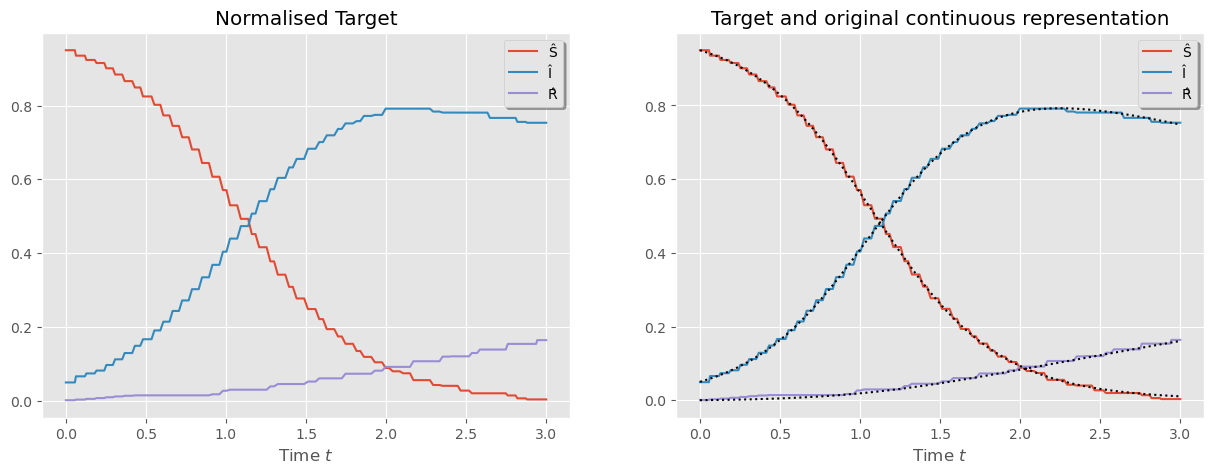

In [19]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, ρ̂.T/n)
plt.plot(Tₑ, ρ̂ₑ.T/n, ':', c='black', linewidth=1.5)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Target and original continuous representation')
plt.show()

## Create a given state

In [20]:
# Give a random initial control
α = asarray([0.01,0.02,0.1])

In [21]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = ρ_sol.sol    # CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

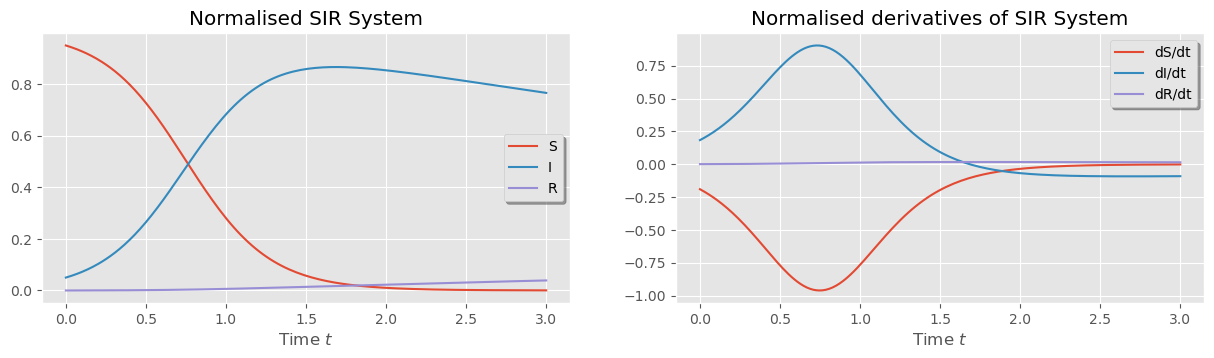

In [22]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIRD(0.0, ρ, α[0], α[1], α[2])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [23]:
def Adjoint(t, z, β,γ,m, ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [24]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,0.1, ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 446 function evaluations.


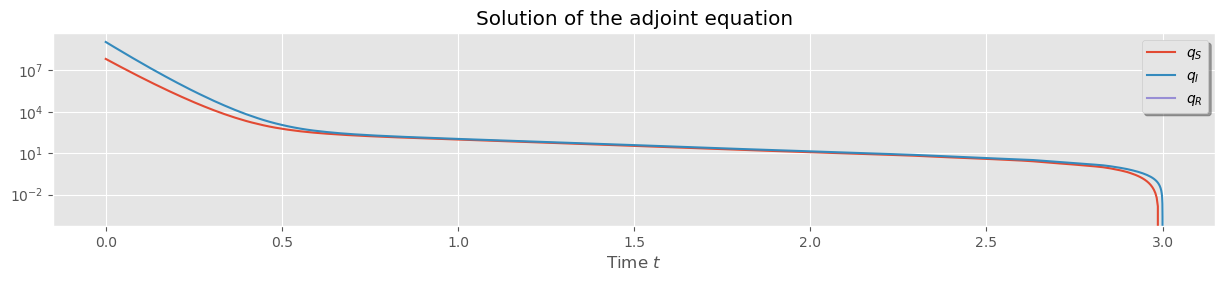

In [25]:
# Plot adjoint curves
plt.figure(figsize=(15,2.5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 +m^2 ).
\end{align}

In [26]:
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,x=Tₑ).sum() + θ * (α**2).sum())
# This one can be two times faster:
#def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson(((ρ-ρ̂)**2).sum(0),x=Tₑ) + θ * (α**2).sum())

In [27]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [28]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+3) ))

As an example, the distance between ρ and ρ̂ is 11594.7031.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} = \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta,
    \qquad
    \frac{\partial f}{\partial \gamma} = \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma,
    \qquad
    \frac{\partial f}{\partial m} = \int\limits_0^T -I q_I  \, \dif t  + \theta m. 
\end{align}

In [29]:
q = solₛ.y[:,::-1]

In [30]:
θ = 0.1
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])  + θ * α
display(df.tolist())

[251759367575.16516, -716288666.3496727, -716259675.1077482]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [31]:
θ = 0.0

In [32]:
global ρ, q
ρ, q = empty((3, Tₑ.size), np.float64), empty((3, Tₑ.size), np.float64)

In [33]:
T_s  = lambda s: np.where(s > 0.0, s**2, 0.0)
dT_s = lambda s: np.where(s > 0.0, 2*s, 0.0)

In [34]:
# Increase tolerance: Quasi-Newton methods are generally more susceptible to numerical errors
# 1e-3 is the default tolerance of the solver, 1e-4 produces fair results and this is replicated in 1e-6
rt = 1e-9
def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    #f += 1e+3 * T_s(α[1] + α[2] - 1.0)
    
    # Create an abstract interpolator for state
    #ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIRD(0,ρ,α[0],α[1],α[2])), axis=-1)
    # Alternative from ODE struct: 
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    df += (θ * α)
    #df += 1e+3 * dT_s(α[1] + α[2] - 1.0)
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0

    return asarray(f)
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    q̂ = q_sol.y[:,::-1]

    # Compute derivative
    dF  = asarray([simpson(ρₐ[0]*ρₐ[1] * (q̂[1]-q̂[0]), x=Tₑ), simpson(ρₐ[1] * (q̂[2]-q̂[1]), x=Tₑ),  -simpson(ρₐ[1] * q̂[1], x=Tₑ)])
    dF /= (n**2) if scaling else 1.0
    dF += (θ * α)

    return asarray(f), dF

---

In [35]:
# Optimal point should be around
# 0.007, 0.1, 0.05
# So we evaluate around this point

In [35]:
# Coarse evaluations (takes a long time)
nβ, nγ, nm = 41, 41, 31
Misfit = zeros([nβ, nγ, nm])
β_axis = linspace(0.001,0.15,nβ)
γ_axis = linspace(0.01,0.2,nγ)
m_axis = linspace(0.01,1,nm)
for (i,β) in enumerate(β_axis):
    #print(i)
    for (j,γ) in enumerate(γ_axis):
        for (k,m) in enumerate(m_axis):
            Misfit[i,j,k] = obj_eval_a( asarray([β,γ,m]) ).item()

In [36]:
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)
M_0, β_0, γ_0, m_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]],    m_axis[i_0[2]]
print('Smallest objective found in the mesh: {0:.4e} with (β,γ,m): ({1:.4f},{2:.4f},{3:.4f})'.format(M_0,β_0,γ_0, m_0))

Smallest objective found in the mesh: 1.5724e-02 with (β,γ,m): (0.0084,0.1002,0.1090)


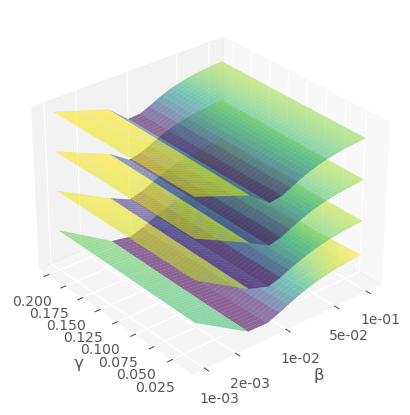

In [37]:
# Create grid of (β,γ)
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')

# Create a 3D plot
fig = plt.figure( figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot surfaces for each z value
for k in [0,10,20,30]:
    # Create a surface plot for each z value and stack them vertically
    ax.plot_surface(np.log(X_c), Y_c, Misfit[:,:,k]+k/10, cmap='viridis', alpha=0.6)

# Set axis labels and title
ax.set_xlabel('β')
ax.set_ylabel('γ')

#ax.set_zlabel('Z (graphically scaled)')
#ax.set_title('Stacked Surface Plots for varying $m$')

ax.view_init(elev=30, azim=230)
ax.set_box_aspect((2, 2, 1.5))

# Set the ticks
ax.set_xticks([-6.9,-6,-4.5,-3,-2]);    #ax.set_yticks([-2.3,-1.5,-0.5,0])
ax.set_xticklabels([f'{val:.0e}' for val in np.exp(ax.get_xticks())])
#ax.set_yticklabels([f'{val:.0e}' for val in np.exp(ax.get_yticks())])
ax.set_zticks([])
ax.set_facecolor('xkcd:white')
plt.show()

# Solving the optimisation problem

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $j$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

To control the success of a direction, which is a linear combination of a proximal direction and the previous step, we define the _predicted reduction_ of $f$ as
\begin{align*}
    \mathrm{pred}_k = j(x_k) - q_k(d_k) = -[\nabla f(x_k)]^\top d_k - \frac{1}{2} \langle d_k, B_k d_k \rangle.
\end{align*}
Here we have omited the evaluation of $\imath_{\mathcal{A}}$ at $x_k$ and $x_k + d_k$ (due to the definition of $d_k$). The _actual reduction_ is defined by $\mathrm{ared}_k = j(x_k) - j(x_k + d_k)$.

The first order residual is defined as $r(x) = \mathrm{prox}_{ \imath_\mathcal{A} }\big(x - \nabla f(x) \big) - x$. 

<div class="alert alert-block alert-warning">
Christian Kanzow & Theresa Lechner. Efficient Regularized Proximal Quasi-Newton Methods for Large-Scale Nonconvex Composite Optimization Problems. Pacific Journal of Optimization (to appear). https://arxiv.org/abs/2210.07644
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Regularised Proximal Quasi–Newton Method</h2>
<ol>
<li>Choose \(x_0 \in \mathrm{dom}(j)\) and a symmetric positive definite matrix \(H_0\). 
    Let parameters satisfy \( \mu_0 > 0 \), \( p_{\min} \in (0, 1/2) \), \(\tau_1 \in (0, 1/2) \), \( \tau_2 \in (\tau_1, 1) \), \( \sigma_1 \in (0, 1) \), \( \sigma_2 > 1 \).
    Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\).
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Choose \( B_k \in \mathcal{M}_n (\mathbb{R}) \) and find a direction $d_k$ given by
    \[
        d_k = \mathrm{prox}_{ \imath_{\mathcal{A}} }^{ B_k + \mu_k \mathsf{I} } \big( x_k - (B_k + \mu_k \mathsf{I})^{-1} \nabla j(x_k) \big) - x_k
    \]
</li>
<li> \(\mathbf{If}\) \( \mathrm{pred}_k \leq p_{\min} \|d_k\| \| r(x_k) \| \) \(\mathbf{then}\)
</li>
<ol>
    <li> Set \( \mu_{k} := \sigma_2 \mu_k\), </li>
    <li> Return to step A. </li>
</ol>
<li> \(\mathbf{else}\) </li>
<ol>    
    <li> Go to step D.</li>
</ol>
    
<li> Set \( \rho_k = \mathrm{ared}_k / \mathrm{pred}_k = \dfrac{ f(x_k + d_{k}) - f(x_k)}{ \nabla f(x_k)^\top d_{k} + \frac{1}{2} \, d_{k} ^\top B_k d_{k} } \) and perform the following updates:
    \[
        x_{k+1} = \begin{cases} x_k & \text{if } \rho_k \leq c_1, \\ x_{k} + d_k & \text{otherwise}; \end{cases}
        \qquad
        \mu_{k+1} = 
        \begin{cases}
            \sigma_2 \mu_k & \text{if } \rho_k \leq \tau_1,
            \\
            \mu_k          & \text{if } \tau_1 < \rho_k \leq \tau_2,
            \\
            \sigma_1 \mu_k & \text{if } \rho_k \geq \tau_2.
        \end{cases}
    \]
<ol>
    <li> Let \(\widehat{m} := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
</ol>
</li>
    
<li> Update \( k \leftarrow k+1\) and go to step A.
</li>
    

    

</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

We skip an update of the method whenever $\langle s_k,y_k\rangle \leq \varepsilon_{\text{LM}} \|s_k\|^2 $.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

In [36]:
# Initial point
β, γ, m = α = rng(80).uniform(0,1,3)
α[0] *= 0.1
α, γ + m

(array([0.07364913, 0.0184188 , 0.03663371]), 0.05505250620295099)

## Algorithm

In [37]:
def RPQN(α, iters=20, save_iter = False, critical = 1):
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Preamble of functions for limited memory ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    dim = α.size            # dimension of the hyperparameter to optimise 
    '''Reserve memory'''
    cLM   = min(3,dim)
    S     = speye(dim, cLM, format = 'csr').A;                        Y = S.copy()
    SY, O = zeros([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
    
    # LM routines: forward, adjoint, transpose, and projections to active set data
    def Limited():
        def B_eval(W,MI,θᵪ, dk):
            db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
        def H_eval(WH,MH,θᵪ, dk):
            db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
        return B_eval, H_eval
    
    # Limited memory functions (two options are available LBFGS or LSR1)
    def LBFGS(S,Y,SY, θ):
        W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
        MI  = inv(MM)
        WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
        MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
        return MI, MH, W, WH
    def LSR1(S,Y,SY, θ):
        W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
        while np.linalg.det(MM) == 0.0:
            # Backtracking
            θ *= 0.5
            W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
            M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
        MI = inv(MM)
        WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
        MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
        return MI, MH, W, WH
    
    Method = 'BFGS'
    
    # Initialise a Gurobi instance for linear solves
    TR_sub = GRB.Model('TR subproblem')
    #TR_sub.Params.Presolve = 0
    TR_sub.setParam('OutputFlag', 0)
    pᵀᴿ = TR_sub.addMVar(shape = dim, vtype = 'C', name = 'p', lb = 0.0, ub = 1.0)
    TR_sub.update()
    
    # Define constraints as a polytope (not needed)
    #Aₚ = bmat([[-speye(dim,format='csr')],[speye(dim,format='csr')]])
    #bₚ = concatenate((zeros(dim), ones(dim)))
    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Create structures to store information from iterates ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    if save_iter:
        every_iter = {a:[] for a in ['it', 'obj', 'time',   'β', 'γ', 'm',  'df_β', 'df_γ', 'df_m', 'norms']}
        every_iter['norms'] = {a:[] for a in ['ℓ_1', 'ℓ_2', 'max', 'min']}
    else:  every_iter = {}
    
    best = {'obj': 1e+10, 'α': None, 'df': None}
    

    
    ''' 
        \\\\\\\\\\\\\\\\\\\\\\
        *** Initialisation ***
        \\\\\\\\\\\\\\\\\\\\\\
    '''
    xₖ = α.copy()      # IMPORTANT to avoid clash with the α defined below (!!!)
    

    # All objects involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
    
    ''' Setting TR parameters '''
    σᵪ = [0.5, 4.0]                  # TR scaling factors  0 < σᵪ[0] < 1 < σᵪ[1] (p 24)
    τᵪ = [1e-4,0.7]                  # TR acceptance ratio (Fail, Success & Increase regions)  0 < τᵪ[0] < τᵪ[1] < 1, τᵪ[0] < ½   [this is c]
    pᵪ = 1e-4                        # Predicted reduction threshold   [this is pₘᵢₙ]
    Δᵪ = 1.0                         # TR radii: μₖ
    θᵪ = 1.0                         # Initial weight for basic Hessian approximation
    mᵪ = 10                           # Memory

    ''' Additional tolerances '''
    εᵪ_LM    = 1e-6                  # Tolerance of curvature sₖᵀyₖ > ε
    εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
    εᵪ_H     = 1e-17                 # Himmeblau criteria
    εᵪ_S     = 1e-18                 # Stationarity criterion
    
    ''' Initial iteration (xₒ, fₒ, dfₒ) '''
    fₖ, dfₖ  = obj_eval(xₖ)
    ''' Initial iteration counter and maximum number of iterations '''
    kᵪ      = 0;
    Max_It  = iters
    
    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Run algorithm for the given settings ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    timed = 0.0              # Clock
    
    kᵪ = 0                      # Iteration count
    kᵢₙₙₑᵣ = 0                   # Subcounter from TR iteration
    while True:

        # Print header of table
        if max(kᵪ,kᵢₙₙₑᵣ) == 0 :
            #print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|'.format('#','‖β‖', '‖γ‖', '‖m‖'), end='')
            print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|'.format('#','β', 'γ', 'm'), end='')
            print('{0:^11s}|{1:^11s}|{2:^11s}|'.format('j(α)','ᵣ‖∇j(α)‖₂','ᵣ‖∇j(α)‖∞'), end='')
            print('{0:^11s}|{1:^11s}|{2:^11s}'.format('μₖ','ᵣ‖d‖₂', 'Time'))
            #print('–'*121)
            print('–'*110)

            # Report initial iteration info
            if save_iter:
                every_iter['it'].append( kᵪ )
                every_iter['obj'].append( fₖ )
                every_iter['time'].append( timed )
                every_iter['β'].append( xₖ[0] )
                every_iter['γ'].append( xₖ[1] )
                every_iter['m'].append( xₖ[2] )
                every_iter['df_β'].append( dfₖ[0] )
                every_iter['df_γ'].append( dfₖ[1] )
                every_iter['df_m'].append( dfₖ[2] )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(dim**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/dim )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            # Store best point
            if fₖ < best['obj']:
                best['obj'] = fₖ
                best['α']   =  xₖ.copy()
                best['df']  = dfₖ.copy()

            '''xₑₙ = xₖ.Ens**0.5
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)) )'''
            
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], xₖ[2]), end = '' )
            print('{0:^11.3e}|{1:^11.3e}|{2:^11.3e}|'.format( fₖ, norm(dfₖ.ravel())/(dim**0.5), norm(dfₖ.ravel(), np.inf) ) )
        
        it_time = time.time()                                             # Clock
        
        # *************** #
        # 1. Find direction
        
        # ––––––––– #
        # Limited memory matrix and operators
        MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ) if (Method == 'BFGS') else LSR1(S,Y,SY, θᵪ)        # Bₖ
        B_eval, H_eval = Limited()
        
        oᵀᴿ = 0.5 * pᵀᴿ @ ((θᵪ+Δᵪ) * pᵀᴿ - W @ (MI @ (W.T @ pᵀᴿ)))             # Define quadratic part of objective, we use Bₖ + μₖ I
        TR_sub.setObjective(oᵀᴿ + (dfₖ @ pᵀᴿ) + fₖ, 1)                          # Add objective and optimisation sense (minimise)
        #TR_sub.update();          print(TR_sub.getObjective())
        pᵀᴿ.LB = -xₖ;        pᵀᴿ.UB = 1.0 - xₖ                                  # Fix feasibility bounds
        #TR_sub.update();          print(pᵀᴿ.LB, pᵀᴿ.UB)
        
        # ––––––––– #
        # Solve subproblem        # TR_sub.addConstr( Aₚ.dot(pᵀᴿ) <= bₚ[::,np.newaxis] );
        #TR_sub.setParam('NumericFocus',3)
        TR_sub.optimize()
        
        dₖ  = pᵀᴿ.x
        Tfₖ, Tdfₖ = obj_eval_d(xₖ + dₖ)                                          # Evaluate direction to be tested
        #print(kᵪ,   xₖ, dₖ, xₖ + dₖ, Tfₖ)
        
        # ––––––––– #
        # Compute predicted reduction
        pred = -dfₖ.dot(dₖ) - 0.5 * dₖ.dot( B_eval(W,MI,θᵪ, dₖ) )
        rₖ   = proj( xₖ - dfₖ  ) - xₖ
        
        # ––––––––– #
        # Test reduction
        if pred <= pᵪ * norm(dₖ) * norm(rₖ):
            Δᵪ *= σᵪ[1]                                                        # Increase penalisation
            if kᵢₙₙₑᵣ == 0:
                print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
            #print(kᵪ,  pred, pᵪ * norm(dₖ) * norm(rₖ))
            print('\033[0;33;2m {0:5.3e} \x1b[0m'.format(Δᵪ), end = ' ')       # Print updated radius
            
            if Δᵪ > 1e+18: #norm(dₖ) < εᵪ_S:
                print('\033[10;42;1m  No more directions  \033[10;42;1m')
                break
        else:
            # *************** #
            # 2. TR update
            
            # ––––––––– #
            # TR reduction ratio
            ρₖ = (fₖ - Tfₖ)/pred
            
            # ––––––––– #
            # Test TR:
            if      ρₖ <= τᵪ[0]:
                Δᵪ *= σᵪ[1]                                                    # Increase penalisation
                if kᵢₙₙₑᵣ == 0:
                    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                print('\033[0;33;2m {0:5.3e} \x1b[0m'.format(Δᵪ), end = ' ')   # Print updated radius
                kᵢₙₙₑᵣ += 1
                
                if Δᵪ > 1e+18: #norm(dₖ) < εᵪ_S:
                    print('\033[10;42;1m  No more directions  \033[10;42;1m')
                    break
                
            else:
                # ––––––––– #
                # Update LM info
                sₖ  = dₖ.copy()                                                 # Point difference (xₖ + dₖ) - xₖ = dₖ
                yₖ  = Tdfₖ - dfₖ                                                # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
                #yₖ.shape, sₖ.shape = (dim,), (dim,)                            # Inplace reshape
                
                # Update LM matrices according to curvature
                ϕᵪ = sₖ.dot(yₖ)                                                 # Compute curvature
                if ϕᵪ >= εᵪ_LM * sₖ.dot(sₖ):
                    θᵪ  = sₖ.dot(yₖ) / yₖ.dot(yₖ)                                # Barzilai-Borwein
                    #print(θᵪ)
                    cLM = min(S.shape[1], mᵪ)                                  # Current LM size
                    
                    if cLM < mᵪ:        # If size is small, add column with secant information
                        S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                        cLM  += 1 
                        SY, O = zeros([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
                    else:               # If size is too large, drop first column
                        S = append(S[:,1:], sₖ[:,None], axis=1)
                        Y = append(Y[:,1:], yₖ[:,None], axis=1)
                    
                
                # ––––––––– #
                # Accept step
                kᵪ += 1
                Hi_rv = abs(fₖ - Tfₖ)/fₖ if (abs(fₖ) > εᵪ_HCond) else abs(fₖ - Tfₖ)            # Relative variation for Himmeblau
                
                xₖ += dₖ
                fₖ, dfₖ = Tfₖ, Tdfₖ.copy()
                
                # ––––––––– #
                # Check if penalisation can be reduced
                if  ρₖ > τᵪ[1]:
                    Δᵪ *= σᵪ[0]
                
                # *************** #
                # Measure time up to this point!
                end = time.time()
                timed += end - it_time
                
                # Reset inner iteration counter
                if kᵢₙₙₑᵣ > 0:
                    print('')
                    kᵢₙₙₑᵣ = 0                # Reset counter
                
                # *************** #
                # Storage and display
                # ––––––––– #
                # Store progress
                if save_iter:
                    every_iter['it'].append( kᵪ )
                    every_iter['obj'].append( fₖ );        every_iter['time'].append( timed )
                    every_iter['β'].append( xₖ[0] );       every_iter['γ'].append( xₖ[1] );        every_iter['m'].append( xₖ[2] )
                    every_iter['df_β'].append( dfₖ[0] );   every_iter['df_γ'].append( dfₖ[1] );    every_iter['df_m'].append( dfₖ[2] )
                    # Store norms of gradient
                    every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(dim**0.5) )
                    #every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(dfₖ.ravel(),1) )
                    every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/dim )
                    every_iter['norms']['max'].append( norm(dfₖ.ravel(), np.inf) )
                    every_iter['norms']['min'].append( abs(dfₖ.ravel()).min() )
                # Store best point
                if fₖ < best['obj']:
                    best['obj'] = fₖ
                    best['α']   =  xₖ.copy()
                    best['df']  = dfₖ.copy()
                
                # Display progress
                if kᵪ % critical == 0:
                    '''xₑₙ = xₖ.Ens**0.5
                    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                        norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)) )'''

                    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1] ,xₖ[2]), end = '' )
                    print('{0:^11.3e}|{1:^11.3e}|{2:^11.3e}|'.format( fₖ, norm(dfₖ.ravel())/(dim**0.5), norm(dfₖ.ravel(), np.inf) ), end = '' )
                    print('{0:^11.3e}|{1:^11.3e}|{2:^11.3g}'.format(Δᵪ, norm(dₖ.ravel())/(dim**0.5), timed))
            
            
                # *************** #
                # Stopping criteria
                # ––––––––– #
                # Himmeblau stopping criterion
                if Hi_rv < εᵪ_H:
                    print('\033[10;42;1m  Himmeblau  \033[10;42;1m')
                    break
                # ––––––––– #
                # Near optimality
                if norm(dₖ) < εᵪ_S:
                    print('\033[10;42;1m  Stationary  \033[10;42;1m')
                    break
                
                
            #print(kᵪ,  xₖ, ρₖ, fₖ)
            #print(kᵪ,  xₖ, fₖ)
        
        # ¡Stop! Maximum iteration count is reached
        if kᵪ == Max_It:
            print('\033[10;41;1m  Maxiter  \033[10;41;1m')
            break

    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Finalise and report *** 
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
    print('\x1b[0m')
    
    # Recompute best objective and state:
    α = best['α']
    jα = obj_eval_a(α)
    #print(α.En, jα)
    print(α, jα)
    
    return α, ρ, every_iter, best

In [38]:
θ = 0.0

In [39]:
ᾱ, ρ, every_iter, best = RPQN(α, iters=200, save_iter = True, critical = 4);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-26
  #  |     β     |     γ     |     m     |   j(α)    | ᵣ‖∇j(α)‖₂ | ᵣ‖∇j(α)‖∞ |    μₖ     |   ᵣ‖d‖₂   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 7.365e-02 | 1.842e-02 | 3.663e-02 | 6.372e-01 | 1.179e+00 | 1.545e+00 |
 TR-radius:  4.000e+00   1.600e+01   6.400e+01  
 TR-radius:  1.280e+02  
 TR-radius:  2.560e+02   1.024e+03  
 TR-radius:  2.048e+03   8.192e+03  
  4  | 9.280e-03 | 4.084e-02 | 5.438e-02 | 5.423e-02 | 1.704e+01 | 2.951e+01 | 4.096e+03 | 2.071e-03 |   0.683   
 TR-radius:  1.638e+04  
  8  | 6.765e-03 | 4.096e-02 | 5.444e-02 | 6.001e-03 | 1.313e-01 | 2.008e-01 | 2.048e+03 | 3.163e-05 |   1.41    
 12  | 6.778e-03 | 4.240e-02 | 5.506e-02 | 5.663e-03 | 1.226e-01 | 1.947e-01 | 1.280e+02 | 4.781e-04 |   2.12    
 16  | 6.662e-03 | 6.249e-02 | 6.333e-02 | 2.916e-03 | 3.856e+00 | 6.678e+00 | 1.600e+01 |

## Iteratively change $\theta$:

We will run the problem for several regularisers:

In [40]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,1)) )
Regularisers.sort()
print(Regularisers)

[0.e+00 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]


In [41]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    
    
    ᾱ, ρ, every_iter, best = RPQN(α, iters=200, save_iter = True, critical = 4)
    


    # Recover dataframe from results
    every_iter['obj'] = asarray(every_iter['obj'])
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)


    # Store info from last iterate
    Out_θ = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():θ}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


  #  |     β     |     γ     |     m     |   j(α)    | ᵣ‖∇j(α)‖₂ | ᵣ‖∇j(α)‖∞ |    μₖ     |   ᵣ‖d‖₂   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 7.365e-02 | 1.842e-02 | 3.663e-02 | 6.372e-01 | 1.179e+00 | 1.545e+00 |
 TR-radius:  4.000e+00   1.600e+01   6.400e+01  
 TR-radius:  1.280e+02  
 TR-radius:  2.560e+02   1.024e+03  
 TR-radius:  2.048e+03   8.192e+03  
  4  | 9.280e-03 | 4.084e-02 | 5.438e-02 | 5.423e-02 | 1.704e+01 | 2.951e+01 | 4.096e+03 | 2.071e-03 |   0.674   
 TR-radius:  1.638e+04  
  8  | 6.765e-03 | 4.096e-02 | 5.444e-02 | 6.001e-03 | 1.313e-01 | 2.008e-01 | 2.048e+03 | 3.163e-05 |   1.38    
 12  | 6.778e-03 | 4.240e-02 | 5.506e-02 | 5.663e-03 | 1.226e-01 | 1.947e-01 | 1.280e+02 | 4.781e-04 |   2.08    
 16  | 6.662e-03 | 6.249e-02 | 6.333e-02 | 2.916e-03 | 3.856e+00 | 6.678e+00 | 1.600e+01 | 6.863e-03 |   2.77    
 TR-radius:  3.2

 TR-radius:  4.000e+00   1.600e+01   6.400e+01  
 TR-radius:  1.280e+02  
 TR-radius:  2.560e+02   1.024e+03  
 TR-radius:  2.048e+03   8.192e+03  
  4  | 9.280e-03 | 4.084e-02 | 5.438e-02 | 5.423e-02 | 1.704e+01 | 2.951e+01 | 4.096e+03 | 2.071e-03 |   0.665   
 TR-radius:  1.638e+04  
  8  | 6.765e-03 | 4.096e-02 | 5.444e-02 | 6.001e-03 | 1.312e-01 | 2.008e-01 | 2.048e+03 | 3.163e-05 |   1.38    
 12  | 6.778e-03 | 4.240e-02 | 5.506e-02 | 5.663e-03 | 1.226e-01 | 1.947e-01 | 1.280e+02 | 4.781e-04 |   2.09    
 16  | 6.723e-03 | 6.251e-02 | 6.334e-02 | 2.570e-03 | 2.889e+00 | 5.002e+00 | 1.600e+01 | 6.868e-03 |   2.79    
 TR-radius:  3.200e+01  
 20  | 6.966e-03 | 8.576e-02 | 6.973e-02 | 5.257e-04 | 1.064e+00 | 1.843e+00 | 3.200e+01 | 8.095e-04 |   3.51    
 TR-radius:  3.200e+01  
 24  | 7.047e-03 | 8.929e-02 | 6.859e-02 | 3.829e-04 | 3.232e-02 | 5.280e-02 | 1.600e+01 | 3.748e-04 |    4.2    
 28  | 7.039e-03 | 9.614e-02 | 6.026e-02 | 2.380e-04 | 5.822e-03 | 6.810e-03 | 1.000e+00 | 2.

 TR-radius:  4.000e+00   1.600e+01   6.400e+01  
 TR-radius:  1.280e+02  
 TR-radius:  2.560e+02   1.024e+03  
 TR-radius:  2.048e+03   8.192e+03  
  4  | 9.221e-03 | 4.083e-02 | 5.437e-02 | 5.254e-02 | 1.692e+01 | 2.929e+01 | 4.096e+03 | 2.077e-03 |   0.671   
 TR-radius:  1.638e+04  
  8  | 6.765e-03 | 4.095e-02 | 5.442e-02 | 6.027e-03 | 1.307e-01 | 2.004e-01 | 2.048e+03 | 3.154e-05 |   1.37    
 12  | 6.777e-03 | 4.239e-02 | 5.504e-02 | 5.691e-03 | 1.230e-01 | 1.943e-01 | 1.280e+02 | 4.770e-04 |   2.07    
 TR-radius:  2.560e+02  
 16  | 6.808e-03 | 4.676e-02 | 5.689e-02 | 4.742e-03 | 1.141e-01 | 1.751e-01 | 6.400e+01 | 8.869e-04 |   2.77    
 20  | 6.955e-03 | 7.087e-02 | 6.471e-02 | 1.329e-03 | 7.897e-02 | 1.097e-01 | 4.000e+00 | 5.837e-03 |   3.46    
 TR-radius:  1.600e+01   6.400e+01   2.560e+02   1.024e+03   4.096e+03   1.638e+04   6.554e+04  
 24  | 6.959e-03 | 7.088e-02 | 6.471e-02 | 1.329e-03 | 4.996e-02 | 7.924e-02 | 6.554e+04 | 7.632e-07 |   4.16    
 28  | 6.960e-03 | 7.

In [46]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,35,0.000180,6.045734,0.007019,0.101398,0.052089,-0.058104,-0.001064,0.002408,0.020525,0.033581,0.058104,0.001064
1.000000e-07,35,0.000180,6.458309,0.007019,0.101401,0.052087,-0.060574,-0.001048,0.002420,0.021347,0.035006,0.060574,0.001048
1.000000e-06,32,0.000179,5.623940,0.007021,0.102885,0.051151,-0.039315,0.002118,0.002964,0.014799,0.022796,0.039315,0.002118
1.000000e-05,32,0.000179,5.653657,0.007021,0.102946,0.051162,-0.037585,0.002311,0.003054,0.014317,0.021812,0.037585,0.002311
1.000000e-04,37,0.000177,6.457200,0.007015,0.102690,0.049717,-0.004775,-0.000497,0.000495,0.001922,0.002786,0.004775,0.000495
1.000000e-03,35,0.000187,6.091918,0.007018,0.101370,0.052067,-0.067780,-0.001041,0.002434,0.023751,0.039163,0.067780,0.001041
1.000000e-02,49,0.000241,8.523397,0.007013,0.102901,0.048868,-0.000118,0.000007,0.000017,0.000047,0.000069,0.000118,0.000007
1.000000e-01,25,0.000814,4.568923,0.007000,0.099506,0.049027,-0.037559,-0.001088,0.000235,0.012961,0.021694,0.037559,0.000235
1.000000e+00,23,0.005385,4.015443,0.006895,0.080992,0.042182,-0.045193,0.000749,0.000361,0.015434,0.026097,0.045193,0.000361


---

In [43]:
#CMap = get_cmap('Wistia')
CMap = colormaps['YlGnBu']
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

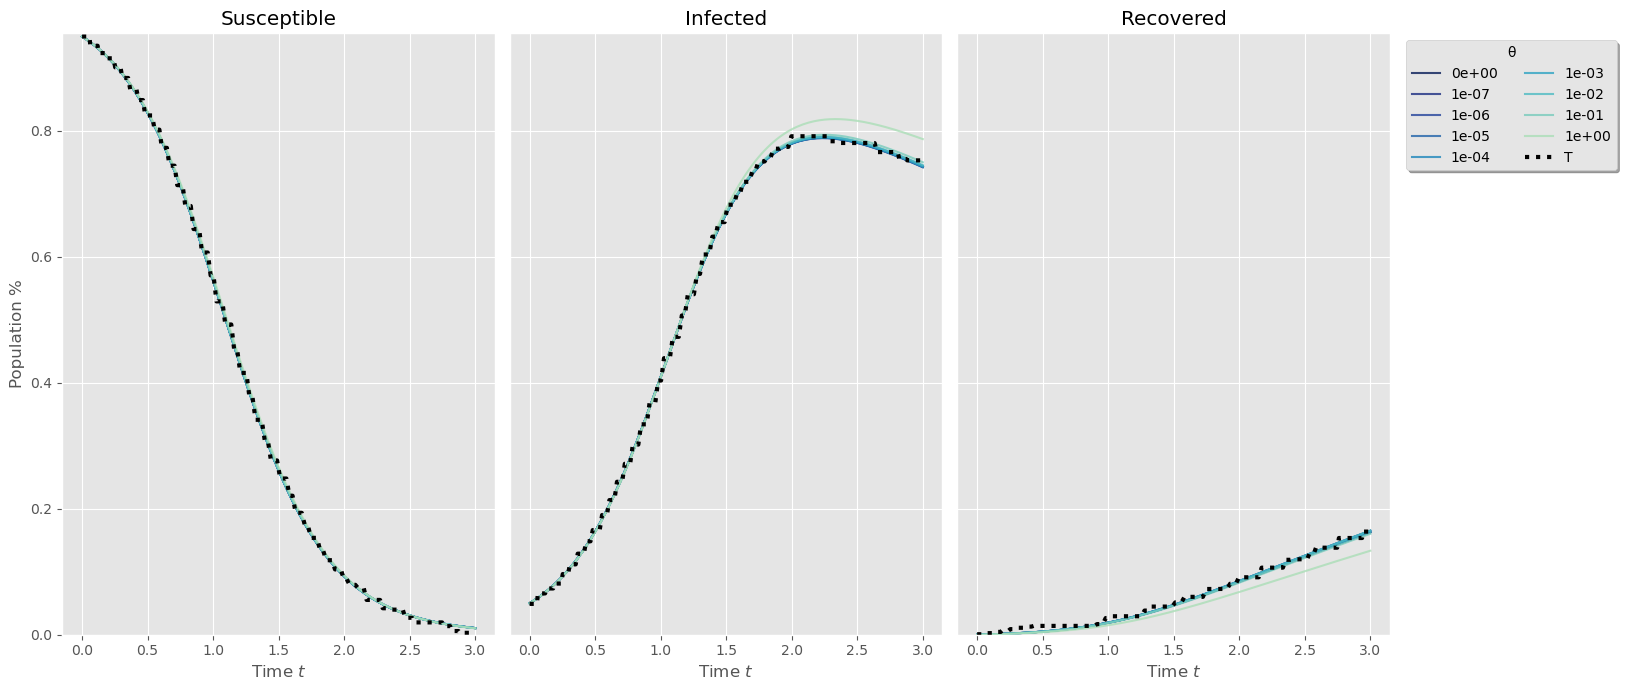

In [44]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/Regularisation – States – RPQN.pdf', bbox_inches='tight', pad_inches=0)

[]

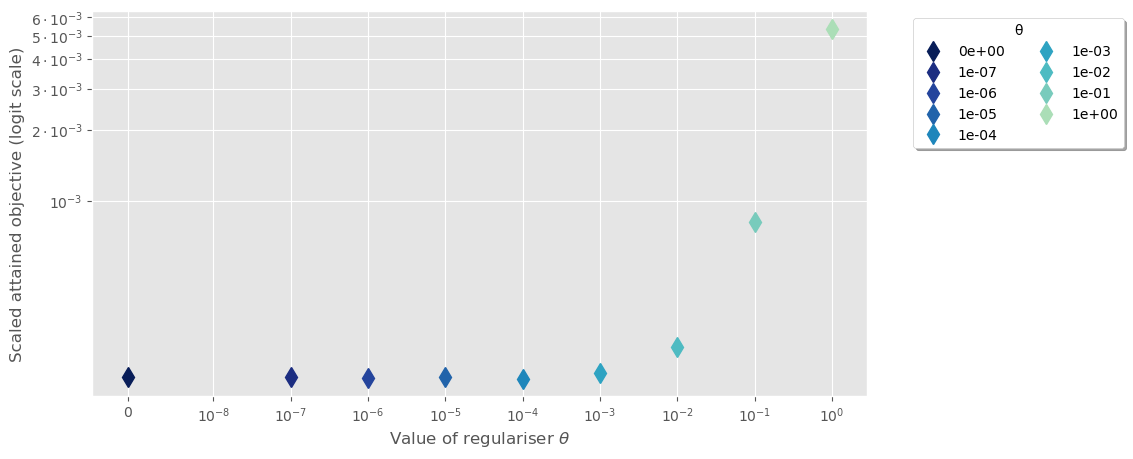

In [45]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].items():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

---

In [46]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,35,0.000180,6.045734,0.007019,0.101398,0.052089,-0.058104,-0.001064,0.002408,0.020525,0.033581,0.058104,0.001064
1.000000e-07,35,0.000180,6.458309,0.007019,0.101401,0.052087,-0.060574,-0.001048,0.002420,0.021347,0.035006,0.060574,0.001048
1.000000e-06,32,0.000179,5.623940,0.007021,0.102885,0.051151,-0.039315,0.002118,0.002964,0.014799,0.022796,0.039315,0.002118
1.000000e-05,32,0.000179,5.653657,0.007021,0.102946,0.051162,-0.037585,0.002311,0.003054,0.014317,0.021812,0.037585,0.002311
1.000000e-04,37,0.000177,6.457200,0.007015,0.102690,0.049717,-0.004775,-0.000497,0.000495,0.001922,0.002786,0.004775,0.000495
1.000000e-03,35,0.000187,6.091918,0.007018,0.101370,0.052067,-0.067780,-0.001041,0.002434,0.023751,0.039163,0.067780,0.001041
1.000000e-02,49,0.000241,8.523397,0.007013,0.102901,0.048868,-0.000118,0.000007,0.000017,0.000047,0.000069,0.000118,0.000007
1.000000e-01,25,0.000814,4.568923,0.007000,0.099506,0.049027,-0.037559,-0.001088,0.000235,0.012961,0.021694,0.037559,0.000235
1.000000e+00,23,0.005385,4.015443,0.006895,0.080992,0.042182,-0.045193,0.000749,0.000361,0.015434,0.026097,0.045193,0.000361


In [47]:
Stats.to_pickle('Outputs/Regularisation – RPQN - Final.pkl') # To read back use pd.read_pickle(file_name)

In [48]:
print(np.around(Stats,6)[['it','time','β','γ','m','obj','norms-ℓ_2']].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & it & time & β & γ & m & obj & norms-ℓ_2 \\
\midrule
0.000000 & 35 & 6.045734 & 0.007019 & 0.101398 & 0.052089 & 0.000180 & 0.033581 \\
0.000000 & 35 & 6.458309 & 0.007019 & 0.101401 & 0.052087 & 0.000180 & 0.035006 \\
0.000001 & 32 & 5.623940 & 0.007021 & 0.102885 & 0.051151 & 0.000179 & 0.022796 \\
0.000010 & 32 & 5.653657 & 0.007021 & 0.102946 & 0.051162 & 0.000179 & 0.021812 \\
0.000100 & 37 & 6.457200 & 0.007015 & 0.102690 & 0.049717 & 0.000177 & 0.002786 \\
0.001000 & 35 & 6.091918 & 0.007018 & 0.101370 & 0.052067 & 0.000187 & 0.039163 \\
0.010000 & 49 & 8.523397 & 0.007013 & 0.102901 & 0.048868 & 0.000241 & 0.000069 \\
0.100000 & 25 & 4.568923 & 0.007000 & 0.099506 & 0.049027 & 0.000814 & 0.021694 \\
1.000000 & 23 & 4.015443 & 0.006895 & 0.080992 & 0.042182 & 0.005385 & 0.026097 \\
\bottomrule
\end{tabular}



---

# Joint plots

In [49]:
Stats  = pd.read_pickle('Outputs/Regularisation – RPQN - Final.pkl')
nmAPG_final = pd.read_pickle('Outputs/Regularisation – nmAPG - Final.pkl')
FISTA_final = pd.read_pickle('Outputs/Regularisation – FISTA - Final.pkl')
PGD_final   = pd.read_pickle('Outputs/Regularisation – PGD - Final.pkl')

In [50]:
PGD_final.head()

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,11,0.004794,0.278489,0.006795,0.045854,0.058053,0.456078,-0.179092,-0.075108,0.236760,0.286195,0.456078,0.075108
1.000000e-07,11,0.004793,0.252664,0.006796,0.045860,0.058058,0.561514,-0.179351,-0.075404,0.272090,0.343099,0.561514,0.075404
1.000000e-06,11,0.004794,0.235712,0.006796,0.045854,0.058053,0.465031,-0.179129,-0.075148,0.239769,0.290969,0.465031,0.075148
1.000000e-05,11,0.004792,0.249170,0.006796,0.045861,0.058060,0.590227,-0.179462,-0.075524,0.281738,0.358831,0.590227,0.075524
1.000000e-04,11,0.004795,0.234607,0.006795,0.045853,0.058052,0.440962,-0.179027,-0.075036,0.231675,0.278166,0.440962,0.075036


Select colours:

In [51]:
from matplotlib   import colormaps
CMap = colormaps['YlGnBu']
colours_BFGS = CMap(linspace(0.3,1,14))

CMap = colormaps['YlOrBr']
colours_GD = CMap(linspace(0.3,1,14))

CMap = colormaps['RdPu']
colours_FISTA = CMap(linspace(0.3,1,14))

CMap = colormaps['BuGn']
colours_nmAPG = CMap(linspace(0.3,1,14))

Attained objective:

In [78]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

[]

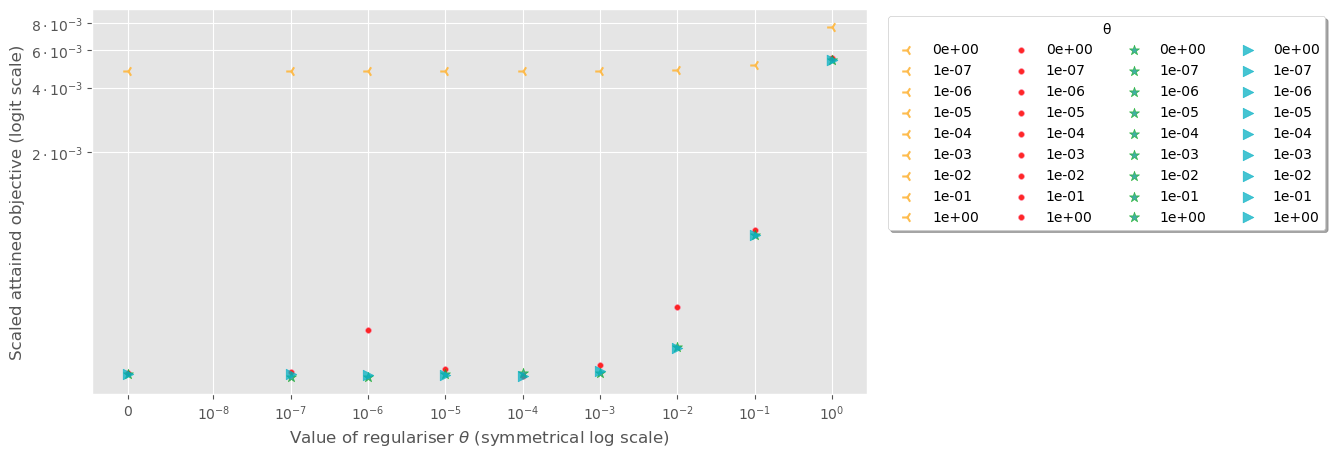

In [52]:
# Plot objective against θ
plt.figure(figsize=(10,5))
    
k = colours_GD.shape[0] - 1
for θ, fᵥ in PGD_final['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = 'gold',#'xkcd:pale gold',#colours_GD[k], 
            #markeredgecolor = "xkcd:robin's egg blue",
             alpha=0.95, #1, 
             marker='3', linestyle = '', markersize = 2*np.log(θ+10),#10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
k = colours_FISTA.shape[0] - 1
for θ, fᵥ in FISTA_final['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_FISTA[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='.', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
k = colours_nmAPG.shape[0] - 1
for θ, fᵥ in nmAPG_final['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_BFGS[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:teal', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:green",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1 
    
k = colours_BFGS.shape[0] - 1
for θ, fᵥ in Stats['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_BFGS[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='>', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right", shadow=True, ncol=4, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$ (symmetrical log scale)');    plt.ylabel('Scaled attained objective (logit scale)')
plt.savefig('Outputs/Regularisation – Objectives -dev.pdf', bbox_inches='tight', pad_inches=0)
plt.plot()

### Evaluate states per algoritm

In [53]:
States_GD = dict()
States_FISTA = dict()
States_nmAPG = dict()

for i in range(Regularisers.size):
    θ = Regularisers[i]
    # PGD
    ω = PGD_final[['β','γ','m']].values[i]
    obj_eval_a(ω);
    States_GD[θ] = ρ.copy()
    # FISTA
    ω = FISTA_final[['β','γ','m']].values[i]
    obj_eval_a(ω);
    States_FISTA[θ] = ρ.copy()
    # nmAPG
    ω = nmAPG_final[['β','γ','m']].values[i]
    obj_eval_a(ω);
    States_nmAPG[θ] = ρ.copy()

In [54]:
CMap = colormaps['YlGnBu']
colours_RPQN = CMap(linspace(0.3,1,10))[::-1]

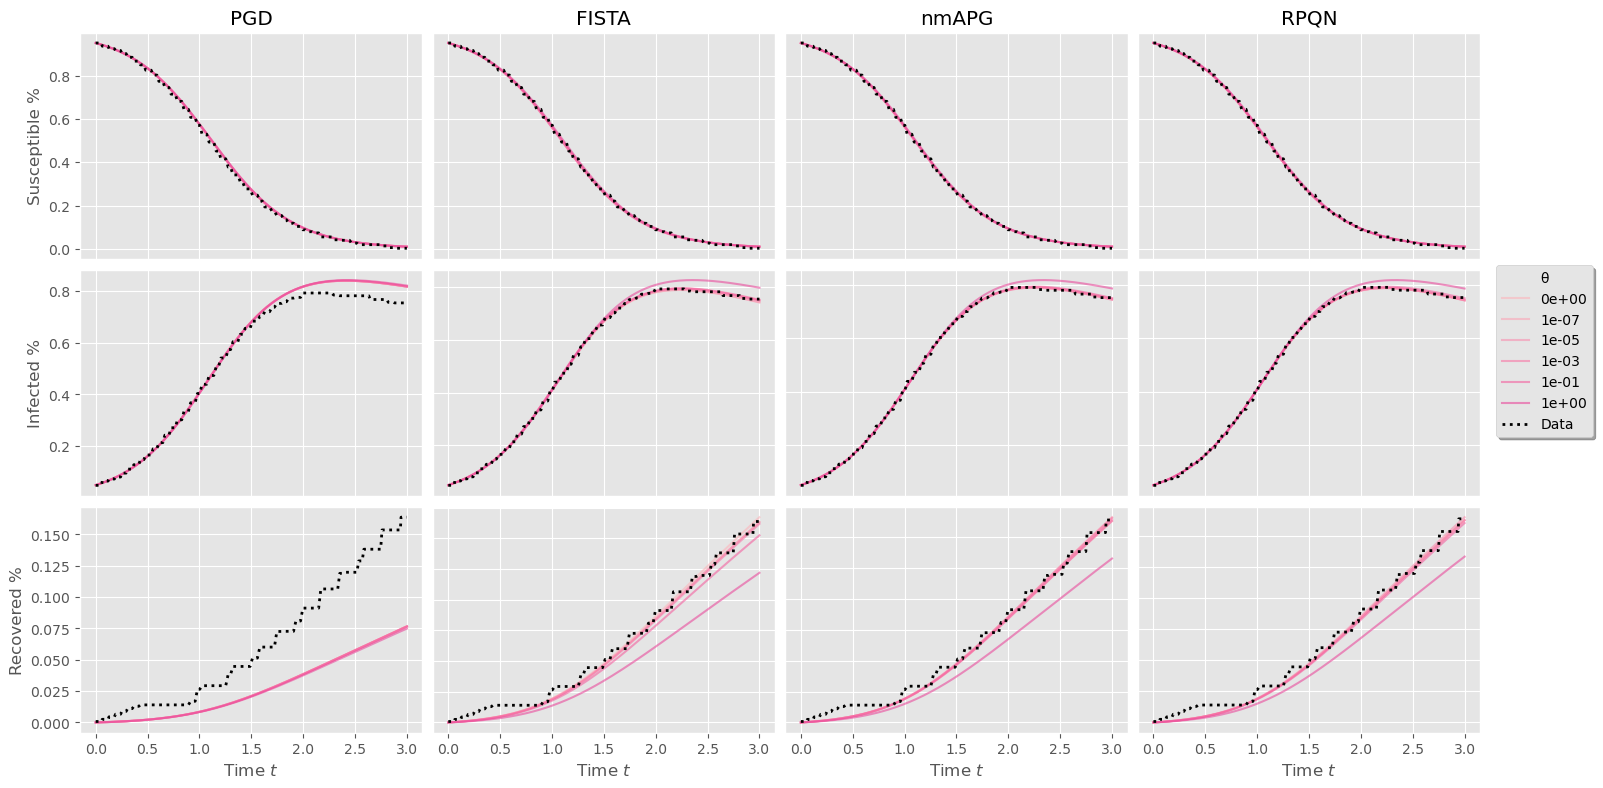

In [55]:
# Plot all states
fig, ax = plt.subplots(3, 4, figsize=(10, 7))
#fig, ax = plt.subplots(3, 4, figsize=(10*0.8, 7*0.8))

# Labels
ax[0,0].set_ylabel(r'Susceptible %');    ax[1,0].set_ylabel(r'Infected %');    ax[2,0].set_ylabel(r'Recovered %')

ax[0,0].set_title(r'PGD');    ax[0,1].set_title(r'FISTA');    ax[0,2].set_title(r'nmAPG');    ax[0,3].set_title(r'RPQN')
for i in range(ax.shape[1]):    ax[-1,i].set_xlabel(r'Time $t$')

k = 0
for θ, ρ in States_GD.items():
    if θ not in Regularisers[[0,1,3,5,7,-1]]:         continue
    ax[0,0].plot(Tₑ, ρ[0]/n, color = colours_FISTA[k], alpha = 0.6)    # Susceptible
    ax[1,0].plot(Tₑ, ρ[1]/n, color = colours_FISTA[k], alpha = 0.6)    # Infected
    ax[2,0].plot(Tₑ, ρ[2]/n, color = colours_FISTA[k], alpha = 0.6)    # Recovered
    k += 1

# FISTA
k = 0
for θ, ρ in States_FISTA.items():
    if θ not in Regularisers[[0,1,3,5,7,-1]]:         continue
    ax[0,1].plot(Tₑ, ρ[0]/n, color = colours_FISTA[k], alpha = 0.6)    # Susceptible
    ax[1,1].plot(Tₑ, ρ[1]/n, color = colours_FISTA[k], alpha = 0.6)    # Infected
    ax[2,1].plot(Tₑ, ρ[2]/n, color = colours_FISTA[k], alpha = 0.6)    # Recovered
    k += 1
    
# nmAPG
k = 0
for θ, ρ in States_nmAPG.items():
    if θ not in Regularisers[[0,1,3,5,7,-1]]:         continue
    ax[0,2].plot(Tₑ, ρ[0]/n, color = colours_FISTA[k], alpha = 0.6)    # Susceptible
    ax[1,2].plot(Tₑ, ρ[1]/n, color = colours_FISTA[k], alpha = 0.6)    # Infected
    ax[2,2].plot(Tₑ, ρ[2]/n, color = colours_FISTA[k], alpha = 0.6)    # Recovered
    k += 1
    
# RPQN
k = 0
for θ, ρ in States.items():
    if θ not in Regularisers[[0,1,3,5,7,-1]]:         continue
    ax[0,3].plot(Tₑ, ρ[0]/n, color = colours_FISTA[k], alpha = 0.6, label = '{0:.0e}'.format(θ))    # Susceptible
    ax[1,3].plot(Tₑ, ρ[1]/n, color = colours_FISTA[k], alpha = 0.6, label = '{0:.0e}'.format(θ))    # Infected
    ax[2,3].plot(Tₑ, ρ[2]/n, color = colours_FISTA[k], alpha = 0.6, label = '{0:.0e}'.format(θ))    # Recovered
    k += 1
    
# Data
for i in range(ax.shape[0]):
    for j in range(4):
        ax[i,j].plot(Tₑ, ρ̂[i]/n, ':', c='black', linewidth=2, label = 'Data')
        #ax[i,j].set_yscale('log')
        if j > 0:
            ax[i,j].set_yticklabels([]);
            for tick in ax[i,j].yaxis.get_major_ticks():    tick.tick1line.set_visible(False)
        if i < ax.shape[0]-1:
            ax[i,j].set_xticklabels([]);
            for tick in ax[i,j].xaxis.get_major_ticks():    tick.tick1line.set_visible(False)
                
# Legend
plt.legend(bbox_to_anchor=(1.35, 2.1), loc="upper right", shadow=True, ncol=1, title='θ')
#plt.legend(bbox_to_anchor=(1.42, 2.07), loc="upper right", shadow=True, ncol=1, title='θ')
#fig.tight_layout()
plt.subplots_adjust(left=0.0, right=1.4, top=1, bottom=0.0, wspace=0.03, hspace=0.05)    # Reduce the spacing between subplots
plt.savefig('Outputs/Regularisation – All States.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

---